# Analyse der MoWaS-Meldungen an NINA
Motiviert durch den [bundesweiten Warntag 2020](https://warnung-der-bevoelkerung.de/) kam die Idee auf, zu analysieren, welche Meldungen durch [MoWaS](https://www.bbk.bund.de/DE/AufgabenundAusstattung/Krisenmanagement/WarnungderBevoelkerung/MoWaS/ModularesWarnsystem_node.html) (Modulares Warnsystem) an die Warn-App [NINA](https://www.bbk.bund.de/DE/NINA/Warn-App_NINA_node.html) gesendet wurden.

Die Daten stammen aus einer [Anfrage](https://fragdenstaat.de/anfrage/ubersicht-uber-warnmeldungen-des-bevolkerungsschutzes-mithilfe-der-app-nina/) an das Bundesamt für Bevölkerungsschutz und Katastrophenhilfe. Die PDF-Datei enthält Warnmeldungen zwischen 2014 und 2017, die Daten sind also nicht wirklich aktuell.

## Einlesen und Datenvorbereitung

### Import der benötigten Module

In [2]:
import camelot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import folium
from folium import plugins

from sklearn.feature_extraction.text import CountVectorizer

### Einlesen der PDF
Die PDF mit den Daten wird mithilfe [Camelot](https://camelot-py.readthedocs.io/en/master/) eingelesen.

In [3]:
tables = camelot.read_pdf("Anlage_1_NINA_bersicht.pdf",pages="all")

In [4]:
df = pd.DataFrame()

Die einzelnen Seiten der PDF-Datei werden einem Pandas DataFrame hinzugefügt.

In [5]:
for i,table in enumerate(tables):
    df = df.append(tables[i].df[1:])

### Benennung der Spalten des DataFrames

Jede Zeile enthält ein Datum, die auslösende Station, den Anlass der Meldung sowie die Anzahl der Aktualisierungen. Die beiden letzten Spalten (Handlungsempfehlungen) sind nicht befüllt.

In [6]:
df.columns = ["Datum", "Station", "Anlass", "Aktualisierungen", "Handlungsempfehlungen_Standard", "Handlungsempfehlungen_manuell"]

Das Einlesen der PDF hat fehlerfrei funktioniert:

In [7]:
df.head()

,Datum,Station,Anlass,Aktualisierungen,Handlungsempfehlungen_Standard,Handlungsempfehlungen_manuell
1,08.04.2014,"Kreis Düren, Amt f. Bev.-schutz S054",kreisweiter Sirenenprobealarm im Kreis Düren,nicht erfasst,nicht erfasst,nicht erfasst
2,12.06.2015,Warnzentrale,Unwetter,nicht erfasst,nicht erfasst,nicht erfasst
3,25.07.2015,ZSVerbSt KA,Unwetter,nicht erfasst,nicht erfasst,nicht erfasst
4,10.08.2015,Düsseldorf,Bombenentschärfung,nicht erfasst,nicht erfasst,nicht erfasst
5,12.08.2015,Düsseldorf,Bombenentschärfung,nicht erfasst,nicht erfasst,nicht erfasst


Insgesamt enthalten die Daten 512 Zeilen (Meldungen).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 512 entries, 1 to 2
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Datum                           512 non-null    object
 1   Station                         512 non-null    object
 2   Anlass                          512 non-null    object
 3   Aktualisierungen                512 non-null    object
 4   Handlungsempfehlungen_Standard  512 non-null    object
 5   Handlungsempfehlungen_manuell   512 non-null    object
dtypes: object(6)
memory usage: 28.0+ KB


### Umwandeln der Datum-Spalte in einen TimeStamp und extrahieren des Jahrs / Monats

In [9]:
df["Datum"] = pd.to_datetime(df["Datum"],dayfirst=True)
df["Monat"] = df["Datum"].dt.month
df["Jahr"] = df["Datum"].dt.year

In den Daten befinden sich Einträge zwischen April 2014...

In [10]:
df["Datum"].min()

Timestamp('2014-04-08 00:00:00')

... und Dezember 2017.

In [11]:
df["Datum"].max()

Timestamp('2017-12-29 00:00:00')

### Wochentage hinzufügen

In [12]:
df["Wochentag"] = df["Datum"].dt.weekday

In [13]:
df["Wochentag_Text"] = df["Datum"].dt.day_name(locale ='de_DE.utf8')

## Analysen

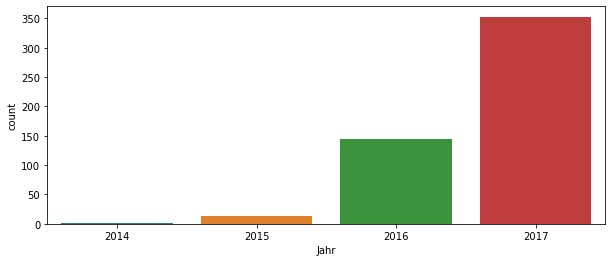

In [14]:
plt.figure(figsize=(10,4))
sns.countplot(x="Jahr",data=df)

In den Daten befinden sich von Jahr zu Jahr steigende Anzahlen von Meldungen.

/home/denis/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


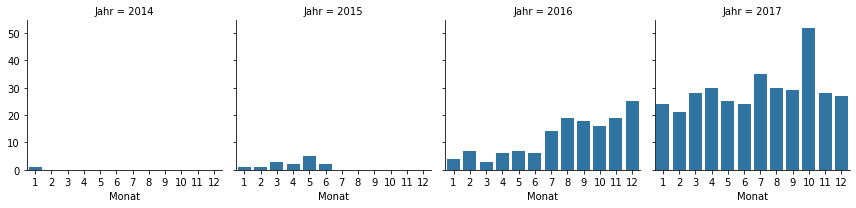

In [15]:
g = sns.FacetGrid(data=df, col="Jahr")
g.map(sns.countplot,"Monat")

In den Jahren 2014 und 2015 gibt es nur Meldungen in der ersten Jahreshälfte. Es ist daher fraglich, ob die Daten vollständig sind.
Im Jahr 2016 zeigt sich ein Trend zu mehr Meldungen in der zweiten Jahreshälfte.

### Häufigkeit der Wochentage

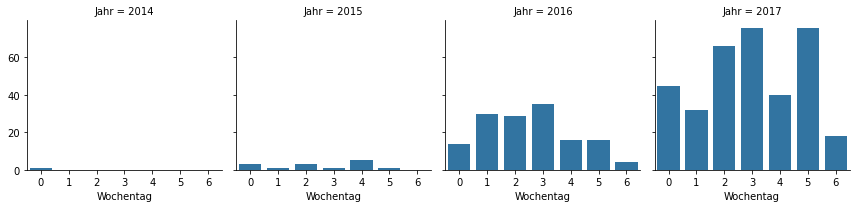

In [16]:
g = sns.FacetGrid(data=df, col="Jahr")
g.map(sns.countplot,"Wochentag")

Der Wochentag 0 entspricht einem Montag, 6 dem Sonntag.
Es fällt auf, dass über alle Jahre signifikant weniger Meldungen an einem Sonntag ausgelöst werden.

### Auslösende Stellen

In [17]:
df["Station"].value_counts().head(10)

BFw Reutlingen S050              28
Düsseldorf                       16
Oberhausen                       16
FW Dortmumd S067                 15
FW Mönchengladbach S053          15
Stadt Duisburg S038              12
Duisburg                         10
FW Oberhausen S055                9
ILS Kreis Recklinghausen S078     9
Bremen                            9
Name: Station, dtype: int64

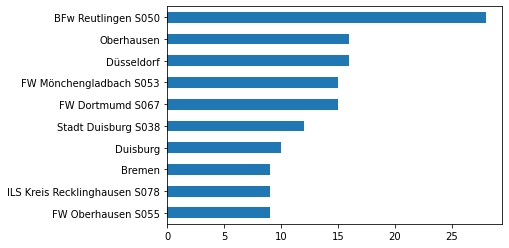

In [18]:
df["Station"].value_counts().head(10).sort_values().plot(kind="barh")

Die Berufsfeuer Reutlingen löste am häufigstens Alarm aus (28 Mal). Den zweiten Platz teilen sich Oberhausen und Düsseldorf. Es fellt auf, dass Duisburg und die Stadt Duisburg als zwei auslösende Stellen erfasst sind - eine Verortung der Alarmmeldung in eine Stadt erscheint sinnvoll.

### Verbessern von Typos
Zuerst verbessern wir aber zwei Tippfehler.

In [19]:
df["Station"] = df["Station"].str.replace("Dortmumd", "Dortmund")
df["Station"] = df["Station"].str.replace("Mühlhein", "Mühlheim")

### Matching der Stationen zu Städten
Die Ortsdaten sind von [Andrena Objects](https://github.com/andrena/java8-workshop/blob/master/demos/Liste-Staedte-in-Deutschland.csv).

In [20]:
city_data = pd.read_csv("Cities.csv",sep=";")

In [21]:
staedte = list(city_data["Stadt"].unique())

Die Methode durchsucht die Stationsspalte nach einer Stadt, die in der Städteliste enthalten ist.

In [22]:
def extractCity(row, staedte):
    candidates = re.split(";|-|/|,| ",row["Station"])

    for candidate in candidates:
        if candidate in staedte:
            return candidate

    for candidate in candidates:
        for stadt in staedte:
                
            if candidate == stadt.split()[0]:
                return stadt
        
    return None

Durchsuche die Spalte *Station* nach Städten.

In [23]:
df["Stadt"] = df.apply(lambda x : extractCity(x,staedte),axis=1)

Übersicht der noch zu verortenden Stationen. Diese sind meinst Stationen eines Bundeslands oder Kreises.

In [24]:
df[df["Stadt"].isnull()]["Station"].value_counts()

LS Rhein-Erft-Kreis S042                 6
IRLS Nordwest S082                       4
LS Ennepe-Ruhr-Kreis S069                3
RLS Lausitz S036                         3
LPD Thüringen S012                       3
LZ der Landesregierung BW, S018          3
LS Märkischer Kreis S095                 3
LZ Sachsen-Anhalt S022                   2
IRLST Nordwest S082                      2
LS Rheinisch-Bergischer Kreis S063       2
Kreis Lippe S041                         2
LS Rhein-Sieg-Kreis S057                 2
ZSVerbSt KA                              1
LS Hochsauerlandkreis S096               1
LZ Baden-Württemberg S018                1
Warnzentrale                             1
IRLS Nordost S079                        1
LZ der Landesregierung ST, S022          1
LZ BW S018                               1
RLS Oderland S080                        1
KLS Rhein-Sieg-Kreis S057                1
Landespolizeidirektion Thüringen S012    1
LZ Bayern S010                           1
Name: Stati

Insgesamt fehlt noch zu knapp 9% der Alarmmeldungen die Stadt.

In [25]:
df.isnull().sum()["Stadt"] / len(df)

0.08984375

Aus Einfachheitsgründen werden diese Zeilen nicht weiter betrachtet.

In [26]:
df = df.dropna()

### Geokodieren der Städte
Wir erstellen einen neuen DataFrame, welcher alle Städte enthält, sodass nur ein Request pro Stadt zum Geokodieren gemacht werden muss. Dabei wird zwischen zwei Request min. eine Sekunde gewartet.

In [27]:
staedte_geoc = df.groupby("Stadt").count()["Datum"].reset_index().rename(columns = {"Datum" : "Meldungen"})

In [28]:
staedte_geoc

,Stadt,Meldungen
0,Aachen,7
1,Berlin,3
2,Bochum,10
3,Bonn,6
4,Borken,4
...,...,...
59,Steinfurt,2
60,Stuttgart,2
61,Trier,10
62,Unna,2


In [29]:
locator = Nominatim(user_agent="nina")

In [30]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

In [31]:
staedte_geoc["Location"] = staedte_geoc["Stadt"].apply(geocode)

Die Spalte *Location* wird in zwei Spalten, welche Breitengrad (*Latitude*) und Längengrad (*Longitude*) enthalten, aufgesplittet.

In [32]:
staedte_geoc[["Latitude", "Longitude"]] = pd.DataFrame(staedte_geoc["Location"].apply(lambda x: tuple(x.point)[:2]).to_list(), index = staedte_geoc.index)

In [33]:
staedte_geoc.head()

,Stadt,Meldungen,Location,Latitude,Longitude
0,Aachen,7,"(Aachen, Städteregion Aachen, Nordrhein-Westfa...",50.776351,6.083862
1,Berlin,3,"(Berlin, Deutschland, (52.5170365, 13.3888599))",52.517037,13.388860
2,Bochum,10,"(Bochum, Nordrhein-Westfalen, Deutschland, (51...",51.481811,7.219664
3,Bonn,6,"(Bonn, Nordrhein-Westfalen, Deutschland, (50.7...",50.735851,7.100660
4,Borken,4,"(Borken, Kreis Borken, Nordrhein-Westfalen, 46...",51.844318,6.858225


Ein paar wenige Städte sind von einer hohen Meldungsanzahl betroffen. In der großen Mehrheit der Städte wurde im Betrachtungszeitraum weniger als 10 Mal gewarnt.

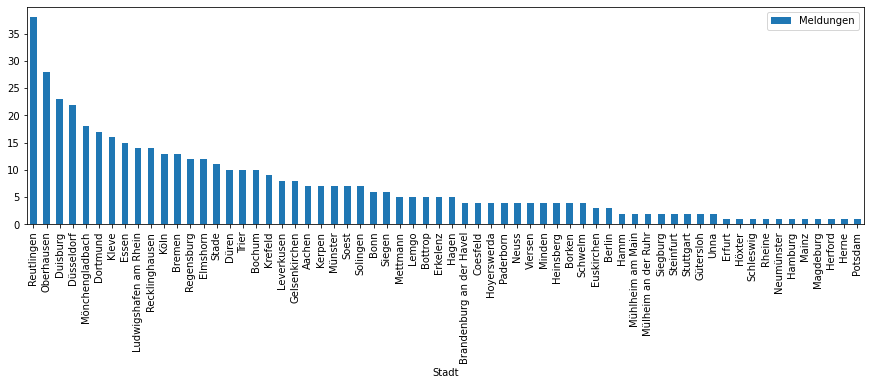

In [34]:
staedte_geoc.sort_values("Meldungen",ascending=False).plot(x="Stadt", y="Meldungen",kind="bar",figsize=(15,4))

### Kartendarstellung
Mit [Folium](https://python-visualization.github.io/folium/) erhält man leicht eine Übersicht der Städte, welche Alarmeldungen ausgelöst haben:

In [35]:
m = folium.Map(location=[50.7, 10.7], zoom_start=6)
staedte_geoc.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]],popup = row["Stadt"],radius=7).add_to(m), axis=1)
m

Wir können die Alarmmeldungen auch mithilfe einer Heatmap darstellen: Es wird heißer, wenn mehr Alarmmeldungen auf engem Raum ausgelöst wurden. Die Heatmap macht hier also eine Aussage über Alarm-Hotspots. Die Häufigkeit von Alarm an einer Lokation lässt sich nicht anhand der Farbe ablesen. Hierzu kann auf einen Kreis geklickt werden: Dann erscheint die Stadt und die Anzahl der Meldungen in dieser.

In [36]:
m = folium.Map(location=[50.7, 10.7], zoom_start=6)

staedte_geoc.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]],popup = row["Stadt"] + ", Meldungen: " + str(row["Meldungen"]),radius=7).add_to(m), axis=1)
heat_data = [[row['Latitude'],row['Longitude'], row["Meldungen"]] for index, row in staedte_geoc.iterrows()]

plugins.HeatMap(heat_data).add_to(m)
m

Möchte man anhand der Stadt auch gleich die Häufigkeit der Meldungen sehen, lässt sich dies auch bewerkstelligen. Deutlich fällt das schon weiter oben erwähnte Reutlingen auf, welches Spitzenreiter mit 38 Meldungen ist.

In [37]:
m = folium.Map(location=[50.7, 10.7], zoom_start=6)

colormap = {0.0: 'green', 0.7: 'yellow', 0.8 : "orange", 1: 'red'}

staedte_geoc.apply(lambda row:folium.Marker(location=[row["Latitude"], row["Longitude"]],popup = row["Stadt"] + ", Meldungen: " + str(row["Meldungen"]), opacity=0.8).add_to(m), axis=1)
heat_data = [[row['Latitude'],row['Longitude'], row["Meldungen"] / staedte_geoc["Meldungen"].max()] for index, row in staedte_geoc.iterrows()]

plugins.HeatMap(heat_data, min_opacity = 0, max_val = 0.00025, gradient=colormap, blur=1,radius=15).add_to(m)
m

### Anlass der Warnung
Interessant ist auch noch, was die häufigsten Gründe für das Auslösen einer Warnung waren.

In [38]:
anlaesse = list(df["Anlass"].unique())

In den Anlässen befinden sich oft auch Städtenamen. Diese wollen wir entfernen:

In [39]:
to_remove = [splitted.lower() for stadt in staedte for splitted in re.split(";|-|/|,| ",stadt)]

bereinigt = []

for anlass in anlaesse:
    splitted = re.split(";|-|/|,| ",anlass)
    
    for element in splitted:
        if element.lower() in to_remove:
            anlass = anlass.replace(element,"").strip()
    bereinigt.append(anlass)

Mithilfe von [NLTK - Natural Language Toolkit](https://www.nltk.org/) kommen wir an eine Liste deutscher Stoppwörter, die wir bei der Häufigkeitsanalyse nicht beachten wollen:

In [40]:
from nltk.corpus import stopwords
german_stop_words = stopwords.words('german')

Mithilfe dieses Code erzeugen wir eine Liste, welche Einträge in Form eines Tupels (Wort, Häufigkeit) enthält:

In [41]:
def get_top_n_words(docs):

    vectorizer = CountVectorizer(stop_words=german_stop_words).fit(docs)
    bag_of_words = vectorizer.transform(docs)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Das Ergebnis verpacken wir direkt wieder in einen DataFrame:

In [42]:
common_words = pd.DataFrame(get_top_n_words(bereinigt),columns=["Wort","Anzahl"])

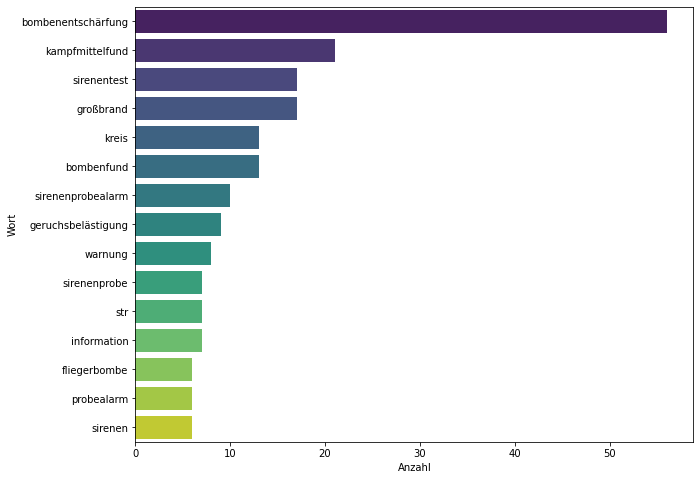

In [43]:
plt.figure(figsize=(10,8))
sns.barplot(y="Wort",x="Anzahl",data=common_words[:15],palette="viridis")

Am häufigsten ist das Wort *Bombenentschärfung* anzutreffen. Geht es allgemein um Kriegsmittel, so werden darunter *Bombenentschärfung, Kampfmittelfund, Fliegerbombe* und *Bombenfund* zusammenfassen zu sein.